# How to use physical units and scaling in Underworld 2?

## A Thermal Convection example 

Romain Beucher

[mailto:romain.beucher@unimelb.edu.au]

I have written a small python module which leverages Pint, a python package used to define and manipulate physical units (https://pint.readthedocs.io). Pint uses a system of unit registries to define a large set of units and most of their prefixes. A Pint Quantity object is a physical value which as a specific  unit attached to itself. Quantity objects can be use in mathematical expressions which also return Quantities in appropriate units.

First of all make sure that you have Pint install on your system. The easiest is to use *pip* in a terminal:

```
[sudo] pip install pint
```


The scaling submodule can then be imported as follow:

In [1]:
import unsupported.scaling as sca

/home/romain/Developement/UNDERWORLD/underworld2/unsupported/scaling/__init__.py:11: UserWarning: 

The scaling module is not supported.

It requires 'pint' as a dependency.

You can install pint by running:

'pip install pint' in a terminal

Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """


The module gives you access to a Pint UnitRegistry which is basically a registry of all units available through Pint.

Lets create an alias to make the following steps easier to read:

In [2]:
u = sca.UnitRegistry

You can now define quantities as follow:

In [3]:
length = 1.0 * u.nautical_mile
length = 1.0 * u.parsec
length = 1.0 * u.kilometer

width = 2.0 * u.kilometer

The *length* and *width* objects are Pint Quantity. I strongly encourage you to explore their different attributes and methods. Use <kbd>tab</kbd> + <kbd>tab</kbd> after the <kbd>.</kbd> to get a list of all the options available.


In [4]:
print length.dimensionality
print length.magnitude
print length.units

[length]
1.0
kilometer


Units are not important here. You can use whatever you want, you can even define your own:

In [5]:
u.define('distance_to_coffee_machine = 57.34 * meters = dtcm')

In [6]:
length = 3.2 * u.distance_to_coffee_machine
print length

3.2 distance_to_coffee_machine


And you can of course convert between units:

In [7]:
length = length.to(u.meter)
print length

183.488 meter


Pint Quantities can be used to calculate derived quantities:

In [8]:
area = length * width
print "area = {0}".format(area) 

area = 366.976 kilometer * meter


# Underworld

Now the Underworld function will not accept pint Quantities as input (yet).
That is where the scaling comes to play.

In [9]:
import underworld as uw

Lets assume that you want a build a simple thermal convection model such as the one in the examples but with some physical units instead of dimensionless values.

The example solves 2D dimensionless isoviscous thermal convection with a Rayleigh number of $10^4$, see Blankenbach *et al.* 1989 for details.

Here are the physical dimension of out model.

In [10]:
# Set simulation box size.
boxHeight = 1000. * u.kilometer
boxLength = 2e6 * u.meter
# Set min/max temperatures.
tempMin = 273.15 * u.degK
tempMax = 1473.15 * u.degK
viscosity = 2.5e19 * u.pascal / u.second
gravity = 9.81 * u.metre**2 / u.second

By default the scaling module gives you a set of scaling coefficient used to normalize your values. It can be accessed as follow:

In [11]:
sca.scaling

{'[length]': <Quantity(1.0, 'meter')>,
 '[mass]': <Quantity(1.0, 'kilogram')>,
 '[substance]': <Quantity(1.0, 'mole')>,
 '[temperature]': <Quantity(1.0, 'kelvin')>,
 '[time]': <Quantity(1.0, 'second')>}

You can see that 5 fundamental dimensions have been defined in term of [Length], [Mass], [Temperature], [Time] and [Substance], following Pint convention.

The scaling coefficients are all equal to 1 by default. Now you can redefine the dimension above so that they can be used in Underworld. The nonDimensinalize function takes makes sure that all units are converted into the SI unit system. 

In [12]:
boxHeight = sca.nonDimensionalize(boxHeight)
boxLength = sca.nonDimensionalize(boxLength)
tempMin   = sca.nonDimensionalize(tempMin) 
tempMax   = sca.nonDimensionalize(tempMax)
viscosity = sca.nonDimensionalize(viscosity)
gravity   = sca.nonDimensionalize(gravity)

In [13]:
print "boxHeight = {0}".format(boxHeight)
print "boxLength = {0}".format(boxLength)
print "tempMin   = {0}".format(tempMin)
print "tempMax   = {0}".format(tempMax)
print "viscosity = {0}".format(viscosity)
print "gravity = {0}".format(gravity)

boxHeight = 1000000.0
boxLength = 2000000.0
tempMin   = 273.15
tempMax   = 1473.15
viscosity = 2.5e+19
gravity = 9.81


All the values above are dimensionless. They have been normalized using the values of the scaling dictionary. Units have been uniformised into the SI system.

Now, we can use the characteritic physical dimensions of our model to define a new set of scaling coefficients such that the length, the temperature gradient and the viscosity are all equal to one.

In [14]:
boxHeight = 1000. * u.kilometer
boxLength = 2e6 * u.meter
tempMin = 273.15 * u.degK
tempMax = 1473.15 * u.degK
viscosity = 2.5e19 * u.pascal * u.second
gravity = 9.81 * u.metre**2 / u.second

KL = boxHeight
KT = tempMax - tempMin
Kt = gravity**-1 * KL**2
KM = viscosity * KL * Kt

# The call to the to_base_units() function is not necessary, but it is useful to check the coefficients.

sca.scaling["[length]"] = KL.to_base_units()
sca.scaling["[temperature]"] = KT.to_base_units()
sca.scaling["[time]"] = Kt.to_base_units()
sca.scaling["[mass]"] = KM.to_base_units()

boxHeight = sca.nonDimensionalize(boxHeight)
boxLength = sca.nonDimensionalize(boxLength)
tempMin   = sca.nonDimensionalize(tempMin) 
tempMax   = sca.nonDimensionalize(tempMax)
viscosity = sca.nonDimensionalize(viscosity)
gravity   = sca.nonDimensionalize(gravity)

print "boxHeight = {0}".format(boxHeight)
print "boxLength = {0}".format(boxLength)
print "tempMin   = {0}".format(tempMin)
print "tempMax   = {0}".format(tempMax)
print "viscosity = {0}".format(viscosity)
print "gravity = {0}".format(gravity)

boxHeight = 1.0
boxLength = 2.0
tempMin   = 0.227625
tempMax   = 1.227625
viscosity = 1.0
gravity = 1.0


To go back to dimension units, one can call the Dimensionalize function:

In [15]:
print "boxHeight in Kilometers: {0}".format(sca.Dimensionalize(boxHeight, units=u.kilometer))
print "boxHeight in dtcm: {0}".format(sca.Dimensionalize(boxHeight, units=u.dtcm))

boxHeight in Kilometers: 1000.0 kilometer
boxHeight in dtcm: 17439.8325776 distance_to_coffee_machine


From now one, any new quantity must be scaled using a call to sca.nonDimenionalize, this makes sure that the value is properly scaled.

In [16]:
thermal_conductivity =  sca.nonDimensionalize(3.0 * u.watt / u.meter / u.degK)
print "Thermal Conductivity = {0}".format(thermal_conductivity)

Thermal Conductivity = 1.49631998803e-06


# Thermal Convection Model

Back to our thermal convection example

In [17]:
import underworld as uw
from underworld import function as fn
import glucifer
import math

In [18]:
nd = sca.nonDimensionalize

In [19]:
boxHeight = 1000. * u.kilometer
boxLength = 2e6 * u.meter
tempMin = 273.15 * u.degK
tempMax = 1473.15 * u.degK
viscosity = 2.5e19 * u.pascal * u.second
gravity = 9.81 * u.metre**2 / u.second

KL = boxHeight
KT = tempMax - tempMin
Kt = gravity**-1 * KL**2
KM = viscosity * KL * Kt

# The call to the to_base_units() function is not necessary, but it is useful to check the coefficients.

sca.scaling["[length]"] = KL.to_base_units()
sca.scaling["[temperature]"] = KT.to_base_units()
sca.scaling["[time]"] = Kt.to_base_units()
sca.scaling["[mass]"] = KM.to_base_units()

boxHeight = sca.nonDimensionalize(boxHeight)
boxLength = sca.nonDimensionalize(boxLength)
tempMin   = sca.nonDimensionalize(tempMin) 
tempMax   = sca.nonDimensionalize(tempMax)
viscosity = sca.nonDimensionalize(viscosity)
gravity   = sca.nonDimensionalize(gravity)

print "boxHeight = {0}".format(boxHeight)
print "boxLength = {0}".format(boxLength)
print "tempMin   = {0}".format(tempMin)
print "tempMax   = {0}".format(tempMax)
print "viscosity = {0}".format(viscosity)
print "gravity = {0}".format(gravity)

boxHeight = 1.0
boxLength = 2.0
tempMin   = 0.227625
tempMax   = 1.227625
viscosity = 1.0
gravity = 1.0


In [20]:
conductivity =  nd(3.0 * u.watt / u.meter / u.delta_degC)
density = nd(3300. * u.kilogram * u.meter**3)
capacity = nd(914 * u.joules / u.kelvin / u.kilogram)

diffusivity = conductivity / (density * capacity)

In [21]:
# Set the resolution.
resx = 32
resy = 16

We create the mesh

In [22]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (resx, resy), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

In [23]:
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

# Initialise values
velocityField.data[...]       =  nd(0. * u.meter / u.second)
pressureField.data[...]       = nd(0. * u.megapascal)
temperatureDotField.data[...] = nd(0.)

In [24]:
# Rayleigh number.
Ra = 1.0e4

# Construct our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, -gravity )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Create initial & boundary conditions
----------

Set a sinusoidal perturbation in the temperature field to seed the onset of convection.

In [25]:
pertStrength = 0.2
deltaTemp = tempMax - tempMin
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

Set top and bottom wall temperature boundary values.

In [26]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

Construct sets for ``I`` (vertical) and ``J`` (horizontal) walls.

In [27]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Create Direchlet, or fixed value, boundary conditions. More information on setting boundary conditions can be found in the **Systems** section of the user guide.

In [28]:
# 2D velocity vector can have two Dirichlet conditions on each vertex, 
# v_x is fixed on the iWalls (vertical), v_y is fixed on the jWalls (horizontal)
velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls, jWalls) )

# Temperature is held constant on the jWalls
tempBC = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                           indexSetsPerDof = (jWalls,) )

**Render initial conditions for temperature**


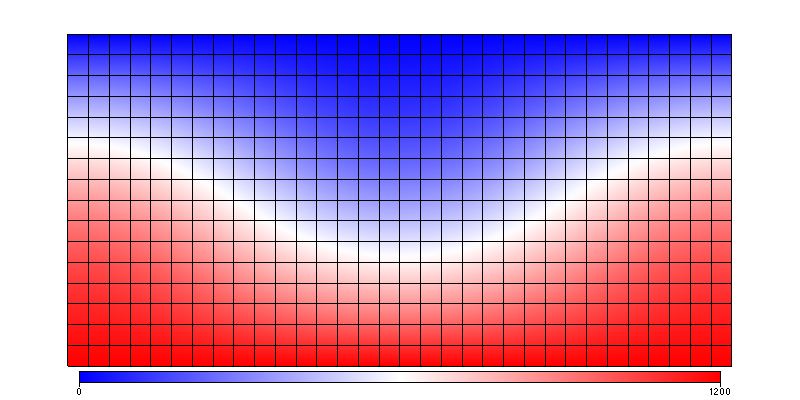

In [29]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, sca.Dimensionalize(temperatureField, u.degC), colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

System setup
-----

**Setup a Stokes system**

Underworld uses the Stokes system to solve the incompressible Stokes equations.  

In [30]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = velBC,
                            fn_viscosity  = viscosity, 
                            fn_bodyforce  = buoyancyFn )

# get the default stokes equation solver
solver = uw.systems.Solver( stokes )

**Set up the advective diffusive system**

Underworld uses the AdvectionDiffusion system to solve the temperature field given heat transport through the velocity field. More information on the advection diffusion equation can be found [here](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation).

In [31]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = diffusivity, 
                                         conditions     = tempBC )

Main time stepping loop
-----

In [32]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

In [33]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection-diffusion system.
    dt = advDiff.get_max_dt()
    # Advect using this timestep size.
    advDiff.integrate(dt)
    
    # pressure correction
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] = pressureField.data[:] -(p0 / area)   
    
    return time+dt, step+1

In [34]:
# init these guys
time = 0.
step = 0
steps_end = 20

# perform timestepping
while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    time, step = update()

**Plot final temperature and velocity field**


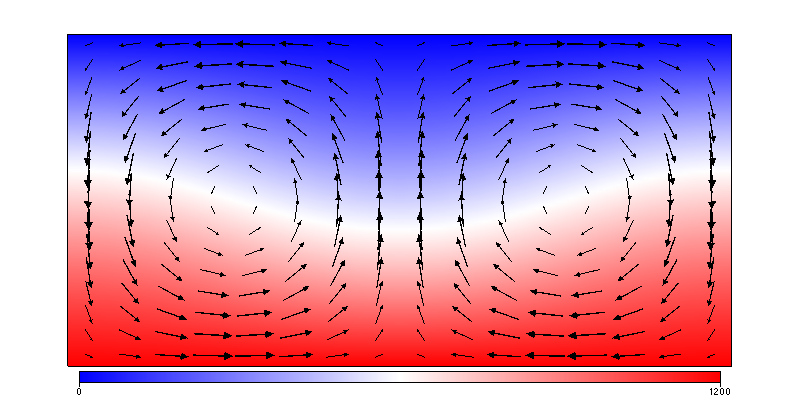

In [35]:
# plot figure
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, sca.Dimensionalize(temperatureField, u.degC), colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/20.0, arrowHead=0.2, scaling=0.1) )
figtemp.show()